In [24]:
import cv2

def extract_frame(video_path, frame_number=0):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Check if video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        return
    
    # Get video properties
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    print(f"Total frames: {total_frames}")
    print(f"FPS: {fps}")
    
    # Set frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    # Read frame
    ret, frame = cap.read()
    
    if ret:
        # # Show frame
        # cv2.imshow(f'Frame {frame_number}', frame)
        
        # # Save frame (optional)
        # cv2.imwrite(f'frame_{frame_number}.jpg', frame)
        
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        print("good")
    else:
        print("Error: Could not read frame.")
    
    # Release video capture object
    cap.release()

    return frame

# Usage examples
video_path = '/cosma7/data/dp004/rrtx34/ultrasound/JCUH/024/JCUH_024_LUS_2/20240118_020902_0009.AVI'

# Extract single frame (frame 10)
frame = extract_frame(video_path, 10)

Total frames: 135
FPS: 22.58
good


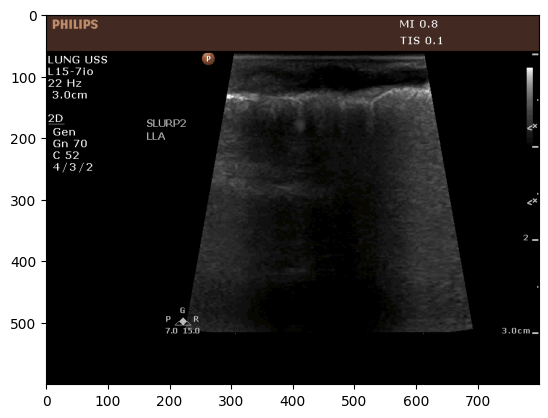

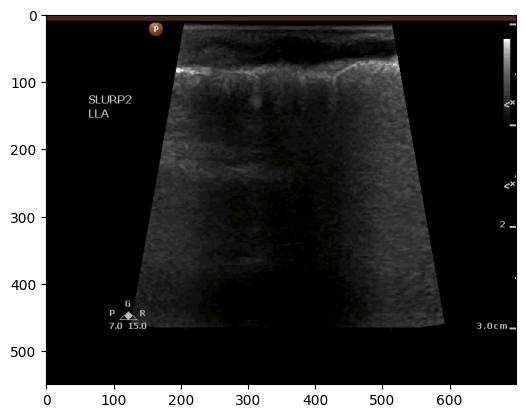

In [25]:
import matplotlib.pyplot as plt

plt.imshow(frame)
plt.show()

# frame_cut = frame[110:280,:300]
# plt.imshow(frame_cut)

scan_label_cut = frame[50:, 100:]
plt.imshow(scan_label_cut)

Using CPU. Note: This module is much faster with a GPU.


Text: SLURP2 (Confidence: 0.58)
Text: LLA (Confidence: 0.99)
Text: PZR (Confidence: 0.83)
Text: 70 (Confidence: 1.00)
Text: 1520 (Confidence: 0.60)
Text: 3Ocmg (Confidence: 0.29)


[('SLURP2', np.float64(0.5809866666126284)),
 ('LLA', np.float64(0.9937017560005188)),
 ('PZR', np.float64(0.8338945856536722)),
 ('70', np.float64(0.9998964889092362)),
 ('1520', np.float64(0.6019213795661926)),
 ('3Ocmg', np.float64(0.29389204981098194))]

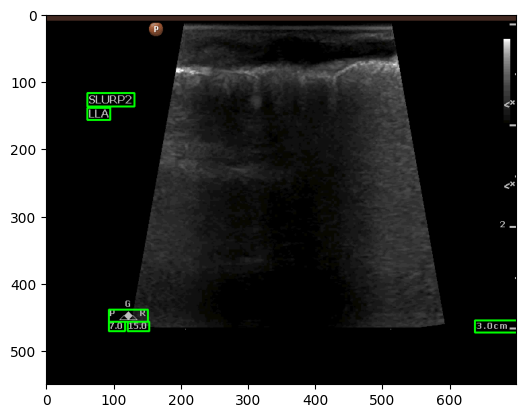

In [26]:
import easyocr
import cv2
import numpy as np

def read_text(image_path, min_confidence=0.0):
    # Initialize reader for English only
    reader = easyocr.Reader(['en'], gpu=False)
    
    if not isinstance(image_path, np.ndarray):
        # Read image
        print("read image")
        image = cv2.imread(image_path)
    else:
        image = image_path
    
    # Perform OCR - lowered text_threshold to catch more detections
    results = reader.readtext(
        image,
        detail=1,
        allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789/',
        text_threshold=0.1,  # Lower threshold to catch more text
        paragraph=False
    )
    
    # Draw results on image and print text
    detected_texts = []
    for (bbox, detected_text, prob) in results:
        # Only include results above minimum confidence
        if prob < min_confidence:
            continue
            
        # Get corner points
        (top_left, top_right, bottom_right, bottom_left) = bbox
        top_left = tuple(map(int, top_left))
        bottom_right = tuple(map(int, bottom_right))
        
    #     # Draw rectangle and text
        cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
    #     cv2.putText(image, detected_text, (top_left[0], top_left[1] - 10),
    #                 cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    
        detected_texts.append((detected_text, prob))
        print(f"Text: {detected_text} (Confidence: {prob:.2f})")
    
    # Display result
    # cv2.imshow("Result", image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    plt.imshow(image)
    return detected_texts

# Usage
image_path = scan_label_cut
read_text(image_path, min_confidence=0.0)  # Set to 0.0 to see all detections

In [ ]:
# Use Text to identify scan label from ultrasound image
